Consider R.A. Fisher's iris dataset which consists of measures of 150 flowers in his gardens. Four dependent variables of their lengths and properties are used to predict the species of flower.

In [1]:
#!pip install Dotua --upgrade

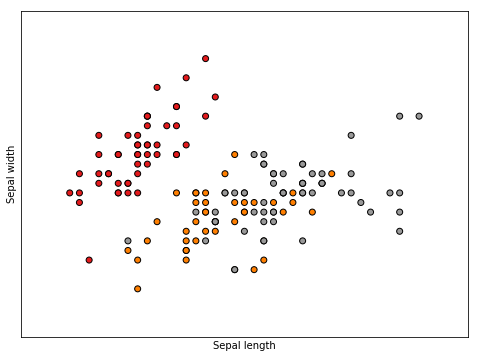

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data 
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

One of the most crucial applications of auto-differentation is backpropagation in neural networks. For some output $\hat{y}$ and set of inputs X, we wish to fix a function $f(x,\theta)$ that is optimized by minimizing a loss function, like MSE:

$$E(w;x;y) = \frac{1}{N}\Sigma_{i=1}^{N}(f_i - y_i)^2 $$

Where N is the number of data points, $f_i$ the value returned by the model and $y_i$ the true value for y at a given observation $i$.

The architecture of a neural network, at the most basic level, is formed by an input layer, a hidden layer, and an output layer. A 'dense' neural network will involve connections between every parameter and these edges each contain a weight value. The task is to paramterize the weights such that a linear combination minimizes the distance between $\hat{y}$ and $y$.




This is accomplished by stacking together a composition of parameters as a dense network whereby each parameter has a weight relative to every other. This captures non-linearities as certain paramters may be more expressive compared to others. The task for the computer is to weight the path on this graph that is the most effective composition of these parameters. A 'dense' neural network will involve connections between every parameter, but a neural network This computational graph approach is no different than the basic dynamic programming idea that is germane to the original motivation of the project.

How do we find this optimal path?

After forward propagating (sometimes using random weights), backpropagation is the crucial step and this is where auto differentation shines. Again, the task is to 'activiate' the neurons or paramters which are most effecirtve at predicting a given outcome. A neural network learns by finding the derivative of our error function with respect to each weight and subtracting this value from the weight value (though sometimes a learning paramter also aguments this process). Automatic differentation -- because it can calculate with machine precision -- is thus an incredibly useful.

To be a little more precise: 

In [3]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2138)

In [4]:
from Dotua.rautodiff import rAutoDiff as rad
from Dotua.roperator import rOperator as op
import random

rad = rad()

class NeuralNetwork():
    def __init__(self, input_vals, input_bias, hidden_bias, num_hidden, output, learning_rate = 0.1):
        self.input_vals = input_vals
        self.input_bias = input_bias
        self.hidden_bias = hidden_bias
        self.num_hidden = num_hidden
        self.output = output
        self.learning_rate = learning_rate

        self.weights_tohidden = [None] * num_hidden
        for i in range(num_hidden):
            self.weights_tohidden[i] = []
            for j in range(len(input_vals)):
                
                #DOTUA USED HERE: to initalize the weights from the input to hidden layer.
                w = rad.create_rscalar(random.random())
                self.weights_tohidden[i].append(w)
        self.weights_tooutput = [None] * len(output)
        for i in range(len(output)):
            self.weights_tooutput[i] = []
            
            #DOTUA USED HERE: to initialize weights from hidden to output.
            w = rad.create_rscalar(random.random())
            for j in range(num_hidden):
                self.weights_tooutput[i].append(w)

    def train(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        #calculation of hidden layer.
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons and error
        error = 0
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            error = error + (o - self.output[i]) ** 2

        # To update weights from hidden layer to output layer
        for i in range(len(self.weights_tooutput)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tooutput[i][j])
                self.weights_tooutput[i][j] = self.weights_tooutput[i][j] - d * self.learning_rate

        # To update weights from input layer to hidden layer
        for i in range(len(self.weights_tohidden)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tohidden[i][j])
                self.weights_tohidden[i][j] = self.weights_tohidden[i][j] - d * self.learning_rate

    def predict(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        # To calculate the hidden layer neurons using the current model
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons using the current model and calculate the error 
        error = 0
        output_layer = []
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            output_layer.append(o.val)
            error = error + (o - self.output[i]) ** 2
        error = error / len(self.output)
        return (output_layer, error.val)

In [9]:
import numpy as np
def get_y(i):
    train_y = [0,0,0]
    train_y[i] = 1
    return train_y

nn = NeuralNetwork(X[0],.35,.6,2,get_y(y[0]))

prediction = []
for j in range(10):
    for i in range(1, len(X)):
        nn.train(X[i], get_y(y[i]))

for i in range(1, len(X)):
    output,e = nn.predict(X[i], get_y(y[i]))
    #print(y_train[i])
    #print(output)
    #print('The mean squared error is ', e)        
    
#for i in range(1, len(X_test)):
#    output,e = nn.predict(X_test[i], get_y(y_test[i]))
# print('Final prediction given by the Neural Network is ', output)
#    print('The mean squared error is ', e)

In [8]:
for i in range(1, len(X)):
    output,e = nn.predict(X[i], get_y(y[i]))
    print('Final prediction given by the Neural Network is ', output)
    print('The mean squared error is ', e)

Final prediction given by the Neural Network is  [0.15012997566249342, 0.2402202116639631, 0.6714866874914475]
The mean squared error is  0.41029305994585
Final prediction given by the Neural Network is  [0.1501472972051093, 0.24023969549964116, 0.6714897905123478]
The mean squared error is  0.4102877555012859
Final prediction given by the Neural Network is  [0.15014751633073317, 0.24023993801436988, 0.6714898251770991]
The mean squared error is  0.4102876857107803
Final prediction given by the Neural Network is  [0.1500937009955077, 0.2401793886492482, 0.6714801677758452]
The mean squared error is  0.41030415717857244
Final prediction given by the Neural Network is  [0.1500511039421427, 0.24013146112931233, 0.671472527293814]
The mean squared error is  0.4103171998148036
Final prediction given by the Neural Network is  [0.1501306741783562, 0.2402209905644363, 0.6714868047201553]
The mean squared error is  0.41029284139785943
Final prediction given by the Neural Network is  [0.15009615

In [ ]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)